Analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [2]:
url = "https://contortion-6c4d5-default-rtdb.firebaseio.com/rotationAnalytics.json"
url = "https://contortion-6c4d5-default-rtdb.firebaseio.com/rotationAnalyticsVersion1.json"

In [3]:
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    
    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        df = pd.DataFrame.from_dict(data, orient='index')
    else:
        print("Unexpected data format:", type(data))
        df = None
        
    if df is not None:
        print(df.head())

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")


                     causeOfDeath                 date gravityToggleUsed  \
-OBj0fzxofBChCxZ7PPd       Spikes  2024-11-15 00:53:13         Not Exist   
-OBj0kCRId331MHGpa7l      Unknown  2024-11-15 00:53:31         Not Exist   
-OBjFf5fdxDfNlHAkhOt      Unknown  2024-11-15 01:58:39         Not Exist   
-OBjFi4D9feWUYiH_keq      Unknown  2024-11-15 01:58:52          Not Used   
-OBjFvqSRO3m6fcP6Yds      Unknown  2024-11-15 01:59:48         Not Exist   

                        level levelStatus  rotations  
-OBj0fzxofBChCxZ7PPd  Level_3     Unknown          2  
-OBj0kCRId331MHGpa7l  Level_3     Unknown          0  
-OBjFf5fdxDfNlHAkhOt  Level_1     Unknown          0  
-OBjFi4D9feWUYiH_keq  Level_2     Unknown          0  
-OBjFvqSRO3m6fcP6Yds  Level_1     Unknown          0  


In [4]:
df = df[~df['level'].str.contains('Tutorial', case=False, na=False)]
df = df[~df['level'].str.contains('Test', case=False, na=False)]

#df.drop(columns=['Test_level'])
print(df.head())

                     causeOfDeath                 date gravityToggleUsed  \
-OBj0fzxofBChCxZ7PPd       Spikes  2024-11-15 00:53:13         Not Exist   
-OBj0kCRId331MHGpa7l      Unknown  2024-11-15 00:53:31         Not Exist   
-OBjFf5fdxDfNlHAkhOt      Unknown  2024-11-15 01:58:39         Not Exist   
-OBjFi4D9feWUYiH_keq      Unknown  2024-11-15 01:58:52          Not Used   
-OBjFvqSRO3m6fcP6Yds      Unknown  2024-11-15 01:59:48         Not Exist   

                        level levelStatus  rotations  
-OBj0fzxofBChCxZ7PPd  Level_3     Unknown          2  
-OBj0kCRId331MHGpa7l  Level_3     Unknown          0  
-OBjFf5fdxDfNlHAkhOt  Level_1     Unknown          0  
-OBjFi4D9feWUYiH_keq  Level_2     Unknown          0  
-OBjFvqSRO3m6fcP6Yds  Level_1     Unknown          0  


In [5]:
average_rotations_per_level = df.groupby('level')['rotations'].mean()
print(average_rotations_per_level)

level
Level_1    3.594488
Level_2    3.090909
Level_3    1.941980
Level_4    2.081871
Level_5    5.347826
Level_6    5.611111
Name: rotations, dtype: float64


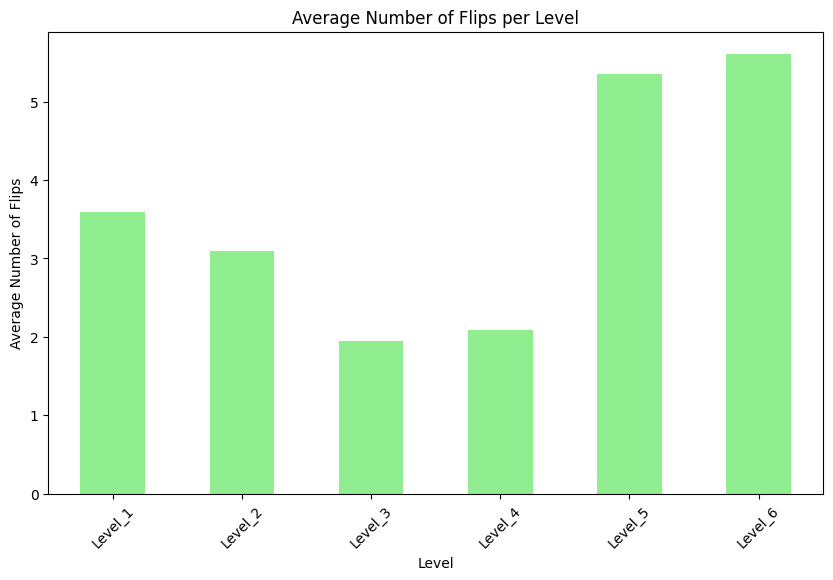

In [6]:

plt.figure(figsize=(10, 6))
average_rotations_per_level.plot(kind='bar', color='lightgreen')
plt.title('Average Number of Flips per Level')
plt.xlabel('Level')
plt.ylabel('Average Number of Flips')
plt.xticks(rotation=45)
plt.show()


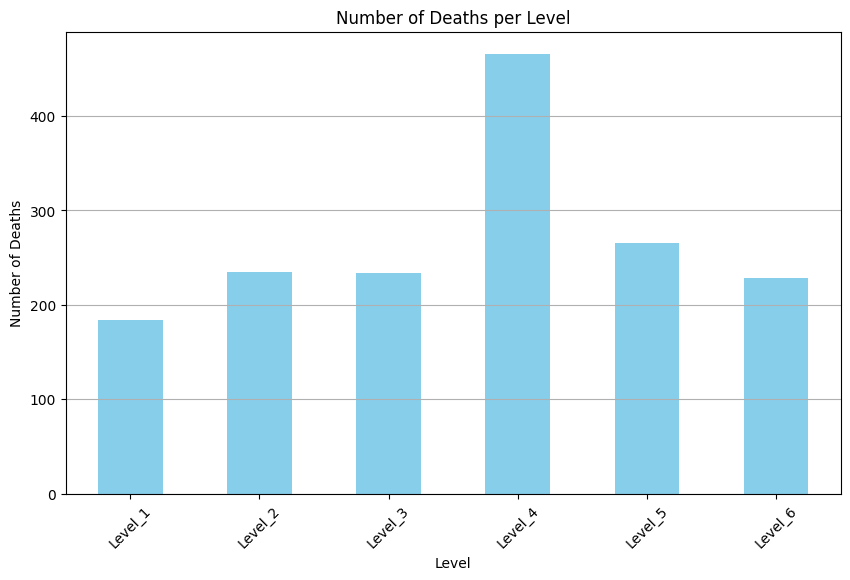

In [7]:
df['causeOfDeath'] = df['causeOfDeath'].replace('Unknown', 'Level Cleared')
death_data = df.dropna(subset=['causeOfDeath'])

df_deaths = death_data[death_data['causeOfDeath'] != 'Level Cleared']

deaths_per_level = df_deaths.groupby('level').size()

plt.figure(figsize=(10, 6))
deaths_per_level.plot(kind='bar', color='skyblue')
plt.title('Number of Deaths per Level')
plt.xlabel('Level')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


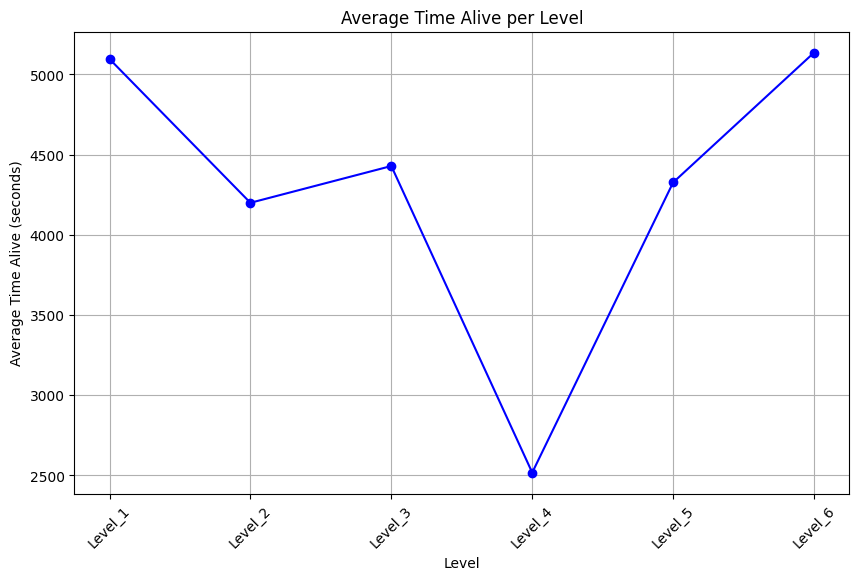

In [8]:
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(by=['level', 'date'])

df['time_alive'] = df.groupby('level')['date'].diff().dt.total_seconds()

df = df.dropna(subset=['time_alive'])

average_time_alive_per_level = df.groupby('level')['time_alive'].mean()

plt.figure(figsize=(10, 6))
average_time_alive_per_level.plot(kind='line', marker='o', color='blue')
plt.title('Average Time Alive per Level')
plt.xlabel('Level')
plt.ylabel('Average Time Alive (seconds)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


               Deaths  Percentage
causeOfDeath                     
Spikes           1281        67.0
Crusher           330        17.3
Level Cleared     302        15.8


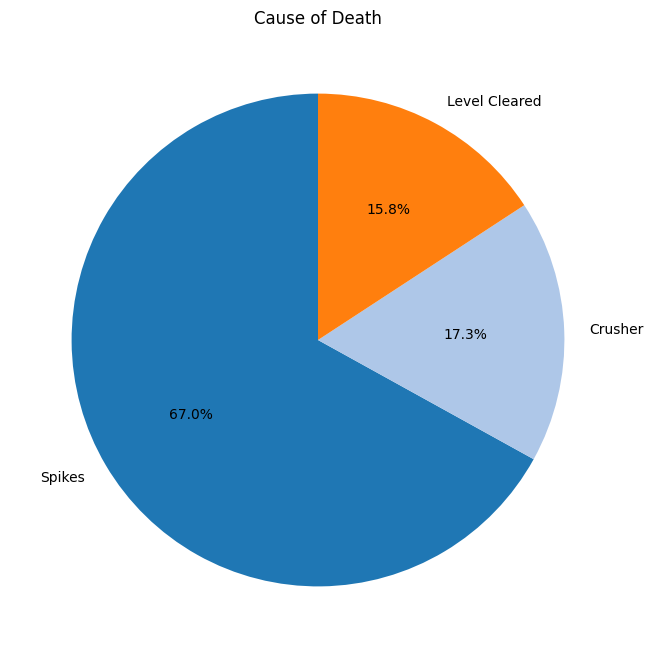

In [9]:
# df = df.dropna(subset=['causeOfDeath'])

df['causeOfDeath'] = df['causeOfDeath'].replace('Unknown', 'Level Cleared')

cause_counts = df['causeOfDeath'].value_counts()

cause_percentage = (cause_counts / cause_counts.sum()) * 100

death_summary = pd.DataFrame({
    'Deaths': cause_counts,
    'Percentage': cause_percentage.round(1)
})

# Display the table
print(death_summary)

# Plot the pie chart
plt.figure(figsize=(8, 8))
cause_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title('Cause of Death')
plt.ylabel('') 
plt.show()


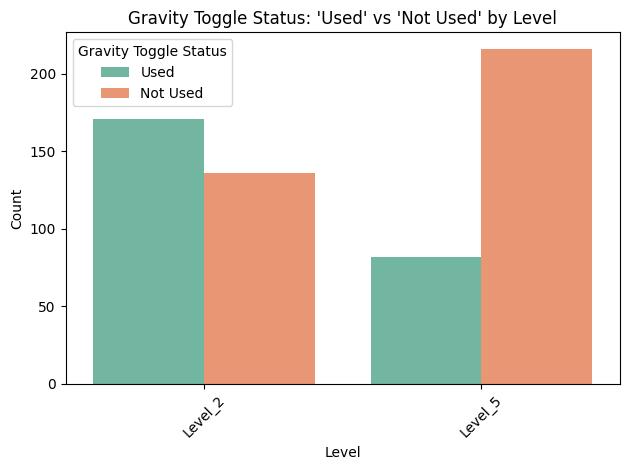

In [10]:
import seaborn as sns

df_filtered = df[df['level'].isin(['Level_2', 'Level_5'])]

total_count = df_filtered.groupby('level').size().reset_index(name='Total')

used_count = df_filtered[df_filtered['gravityToggleUsed'] == 'Used'].groupby('level').size().reset_index(name='Used')

counts = pd.merge(total_count, used_count, on='level', how='left').fillna(0)
counts['Not Used'] = counts['Total'] - counts['Used']

plot_data = counts.melt(id_vars='level', value_vars=['Used', 'Not Used'], var_name='Gravity Toggle Status', value_name='Count')

sns.barplot(data=plot_data, x='level', y='Count', hue='Gravity Toggle Status', palette='Set2')
plt.title("Gravity Toggle Status: 'Used' vs 'Not Used' by Level")
plt.xlabel("Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()